<a href="https://colab.research.google.com/github/krissylee/data_601_final_project/blob/main/Analysis_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maryland Statewide Vehicle Crashes Analysis in 2020-2021

# Prerequisite
  ***** Please put all the CSV files under 'dataset' folder for the codes to run properly *****

# 1. Data Cleaning

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from numpy import asarray
from sklearn.preprocessing import LabelEncoder


In [ ]:
person = pd.read_csv('dataset/cleaned-person.csv')
crash = pd.read_csv('dataset/cleaned-crash.csv')
vehicle = pd.read_csv('dataset/cleaned-vehicle.csv')

FileNotFoundError: ignored

In [ ]:
merged_data = pd.read_csv('dataset/merged-data.csv')

## 1.1 Take a look at the datatype - merged data

In [ ]:
dtype_merged = merged_data.dtypes.reset_index()
dtype_merged.columns = ['Data Name', 'Data Type']
dtype_merged

,Data Name,Data Type
0,REPORT_NO,object
1,YEAR.x,int64
2,QUARTER,object
3,LIGHT_DESC,object
4,COUNTY_DESC,object
5,COLLISION_TYPE_DESC,object
6,SURF_COND_DESC,object
7,REPORT_TYPE,object
8,WEATHER_DESC,object
9,HARM_EVENT_DESC1,object


## 1.2 Transform date of birth to age 

In [ ]:
# Take a look at the original date of birth data type
merged_data.DATE_OF_BIRTH.dtype

dtype('float64')

In [ ]:
# Convert this variable from float to string, then split the decimal for a tidy format
merged_data['DATE_OF_BIRTH'] = merged_data['DATE_OF_BIRTH'].astype(str).apply(lambda x: pd.to_datetime(x.split('.')[0],
                                                                  format = '%Y%m%d'))

In [ ]:
# Take a look at the data type again, now we are good to go 
merged_data.DATE_OF_BIRTH.dtype

dtype('<M8[ns]')

In [ ]:
# Generate the new age column
merged_data['age'] = merged_data['DATE_OF_BIRTH'].apply(lambda x: (pd.datetime.now().year - x.year))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [ ]:
# # Seems good!
merged_data['age']

0         46.0
1         46.0
2         56.0
3         56.0
4         54.0
          ... 
754287    68.0
754288    49.0
754289    42.0
754290    62.0
754291    31.0
Name: age, Length: 754292, dtype: float64

## 1.3 Create lists for numerical and categorical data

In [ ]:
num_var = [feature for feature in merged_data if merged_data[feature].dtypes == 'int' or merged_data[feature].dtypes == 'float']
cat_var = [feature for feature in merged_data if merged_data[feature].dtypes == 'object']

In [ ]:
num_var

['YEAR.x',
 'ACC_DATE',
 'LATITUDE',
 'LONGITUDE',
 'YEAR.y',
 'AIRBAG_DEPLOYED',
 'YEAR',
 'VEH_YEAR',
 'SPEED_LIMIT',
 'age']

In [ ]:
cat_var

['REPORT_NO',
 'QUARTER',
 'LIGHT_DESC',
 'COUNTY_DESC',
 'COLLISION_TYPE_DESC',
 'SURF_COND_DESC',
 'REPORT_TYPE',
 'WEATHER_DESC',
 'HARM_EVENT_DESC1',
 'HARM_EVENT_DESC2',
 'ACC_TIME',
 'LOCATION',
 'Quarter.x',
 'SEX_DESC',
 'SEX_CODE',
 'INJ_SEVER_DESC',
 'ALCOHOL_TEST_DESC',
 'ALCOHOL_TESTTYPE_DESC',
 'DRUG_TEST_DESC',
 'DRUG_TESTRESULT_DESC',
 'EJECT_DESC',
 'SAF_EQUIP_DESC',
 'Quarter.y',
 'HARM_EVENT_DESC',
 'VEH_MAKE',
 'GOING_DIRECTION_DESC',
 'HIT_AND_RUN_FLAG_DESC']

In [ ]:
# Remove duplicated values
print(merged_data.duplicated().sum())
merged_data = merged_data.drop_duplicates()

0


In [ ]:
# Generate descriptive statistics on the merged dataset
merged_data.describe()

,YEAR.x,ACC_DATE,LATITUDE,LONGITUDE,YEAR.y,AIRBAG_DEPLOYED,YEAR,VEH_YEAR,SPEED_LIMIT,age
count,754292.000000,7.542920e+05,754292.000000,754292.000000,754292.000000,746972.000000,754292.000000,720036.000000,754292.000000,684929.000000
mean,2020.456571,2.020519e+07,39.134881,-76.733551,2020.456567,4.888602,2020.456567,2006.988616,35.271460,38.095804
std,0.498111,4.926820e+03,0.307275,0.453939,0.498110,18.255564,0.498110,163.860282,15.506001,18.205998
min,2020.000000,2.020010e+07,37.000000,-79.989756,2020.000000,0.000000,2020.000000,0.000000,0.000000,0.000000
25%,2020.000000,2.020070e+07,38.966947,-76.928894,2020.000000,1.000000,2020.000000,2007.000000,25.000000,25.000000
50%,2020.000000,2.020120e+07,39.212977,-76.708266,2020.000000,1.000000,2020.000000,2013.000000,35.000000,35.000000
75%,2021.000000,2.021052e+07,39.336406,-76.574505,2021.000000,2.000000,2021.000000,2017.000000,45.000000,51.000000
max,2021.000000,2.021093e+07,39.994802,-75.000747,2021.000000,99.000000,2021.000000,9999.000000,75.000000,121.000000


# 2. EDA

# 2.1 Numerical Data 

In [ ]:
# Once again, we load the numerical variables for reference
num_var

['YEAR.x',
 'ACC_DATE',
 'LATITUDE',
 'LONGITUDE',
 'YEAR.y',
 'AIRBAG_DEPLOYED',
 'YEAR',
 'VEH_YEAR',
 'SPEED_LIMIT',
 'age']

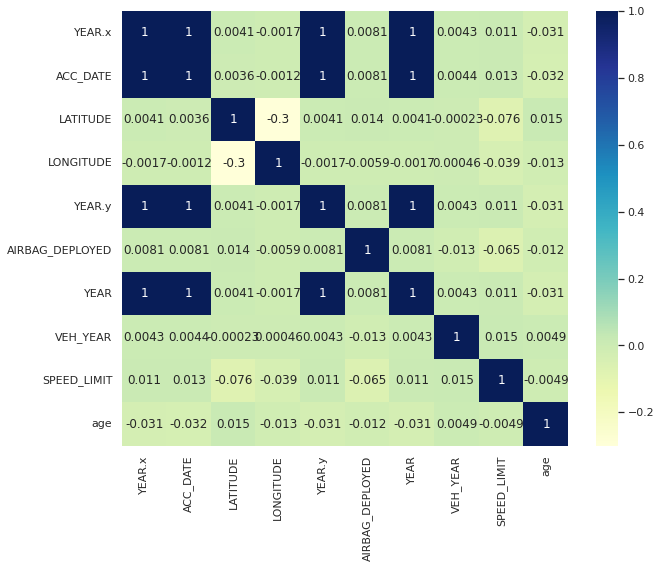

In [ ]:
# Take a look at the correlation among all variables
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(merged_data.corr(), annot = True, cmap = 'YlGnBu')

There seems no significant coorelation between numerical variables.

Year.X


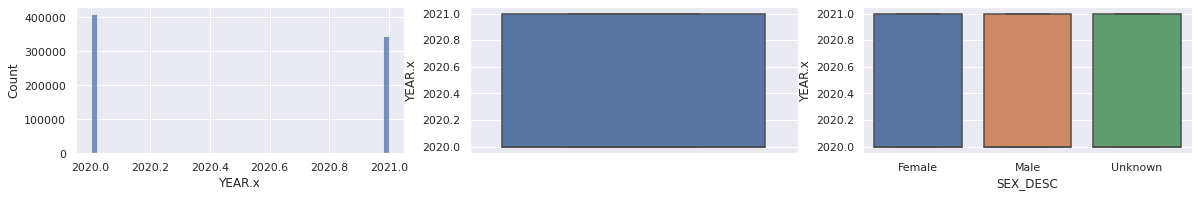

Acc_Date


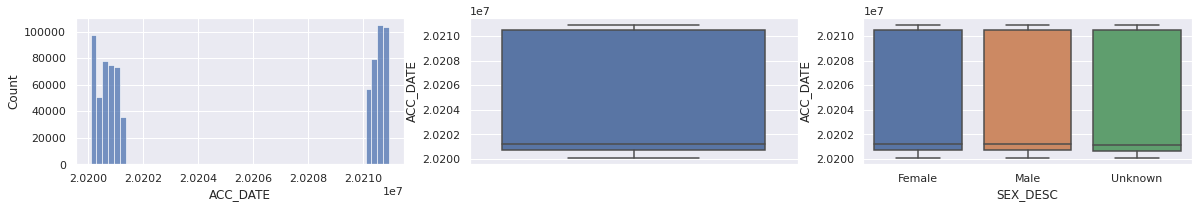

Latitude


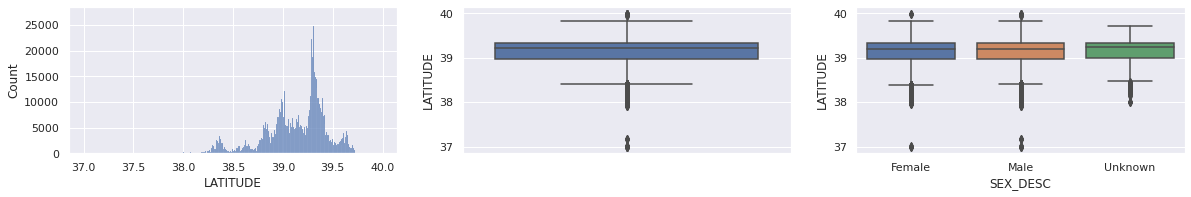

Longitude


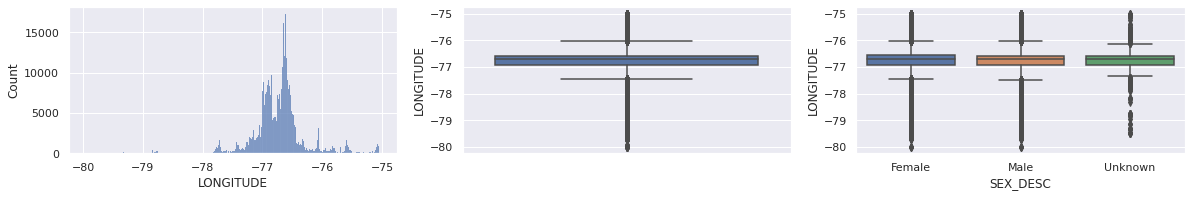

Year.Y


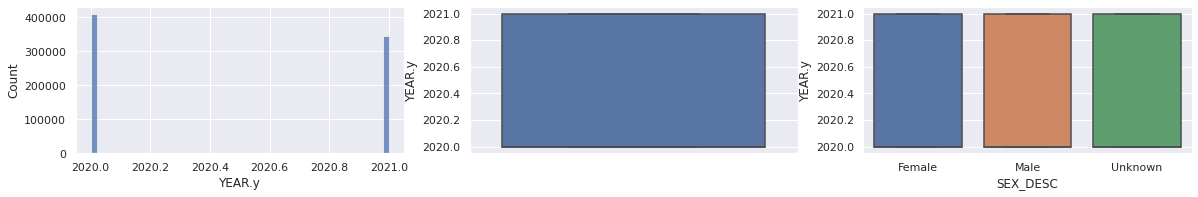

Airbag_Deployed


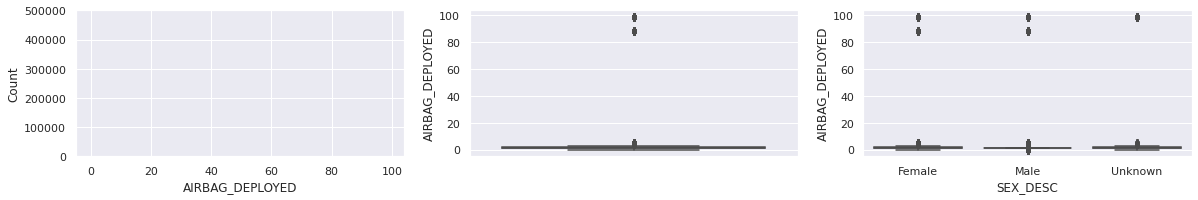

Year


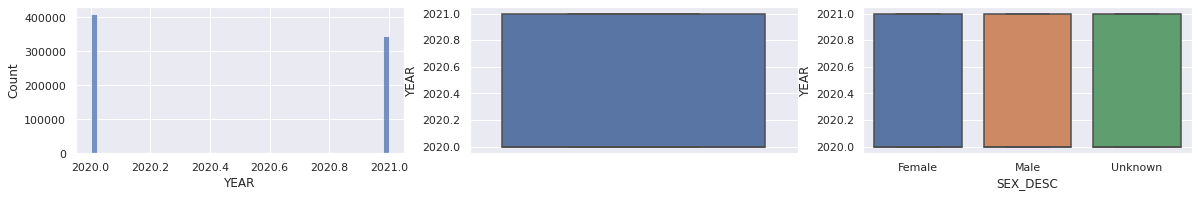

Veh_Year


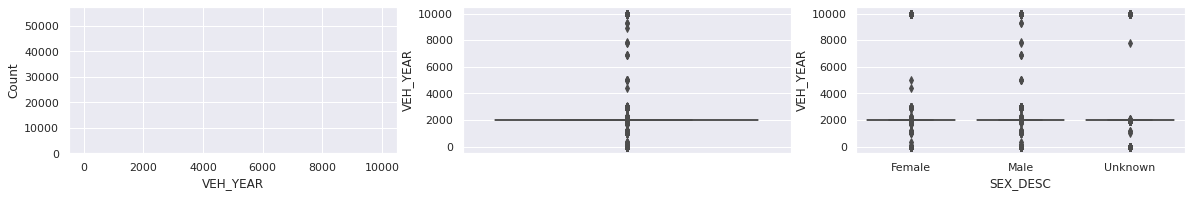

Speed_Limit


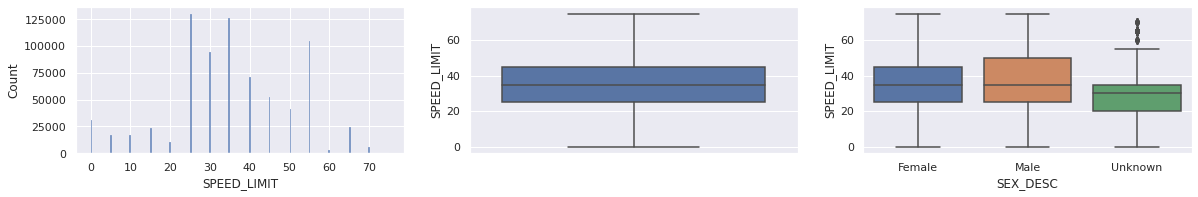

Age


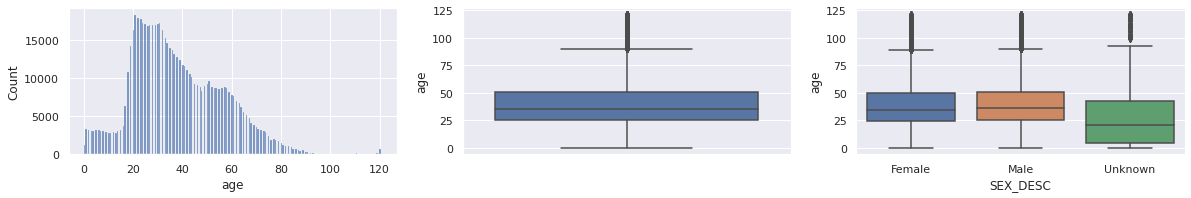

In [ ]:
# Visualize all numerical variables
sns.set(style='darkgrid')

i = 1
for column in num_var:
    print(column.title())
    plt.subplots(figsize = (20, 35))
    plt.subplot(len(num_var) + 1, 3, i)
    sns.histplot(x = merged_data[column])
    i += 1
    plt.subplot(len(num_var) + 1, 3, i)
    sns.boxplot(y = merged_data[column])
    i += 1
    plt.subplot(len(num_var) + 1, 3, i)
    sns.boxplot(x = merged_data['SEX_DESC'], y = merged_data[column])
    i += 1
    plt.show()

From the plots above, we can gain these insights below:
1. Among the accidents in 2020, there's a significant drop in the spring of 2020. Even if it has some fluctuations, the number of accidents are in average around 8,0000. As for those in 2021, the accident number is steadily increasing. However, accidents are more common in 2020 than 2021. 
2. The most three common speed limit values in this crash data are 25, 35, and 55. Intrestingly, though female drivers and male drivers share a similar speed limit median value, which is around 38, more male drivers tend to drive faster than female drivers in general. 
3. Among accidents in 2020-2021, the common age range for drivers is between 20-40, which indicating Gen Z and Millennials are subject to car crashes.

## 2.1.2 Time Series Anlysis in accidents ( week, hour, month, year)

In [ ]:
# Convert string to datetime object
crash['accident_date'] = pd.to_datetime(crash['ACC_DATE'], format='%Y%m%d')
crash['accident_year'] = crash['accident_date'].dt.strftime('%Y')
crash['accident_month'] = crash['accident_date'].dt.strftime('%m')
crash['accident_year_month'] = crash['accident_date'].dt.strftime('%Y-%m')

NameError: ignored

In [ ]:
# Get accidents count grouped by year and month
crashes_by_year_month = crash.groupby(['accident_year_month']).size()
crashes_by_year_month

NameError: ignored

In [ ]:
# Group accident data by three different subsets (Baltimore Couty, Baltimore City, and Prince George's County) - these are the counties which have the highest vehicle 
# crashes numbers from 2020 to 2021
baltimore_crashes = crash[crash['COUNTY_DESC']=='Baltimore']
baltimore_city_crashes = crash[crash['COUNTY_DESC']=='Baltimore City']
prince_georges_crashes = crash[crash['COUNTY_DESC']=='Prince George\'s']

In [ ]:
# Get accidents count by year month for the top three vehicle crashes counties
baltimore_city_crashes_by_year_month = baltimore_city_crashes.groupby(['accident_year_month']).size()
baltimore_crashes_by_year_month = baltimore_crashes.groupby(['accident_year_month']).size()
prince_georges_crashes_by_year_month = prince_georges_crashes.groupby(['accident_year_month']).size()

In [ ]:
# Visualize the accidents count by year month in a line group
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_ylim(0, 12000)
plt.title("Maryland Statewide Vehicle Crashes from 2020 to 2021", fontsize=16)
plt.ylabel('Vehicle Crashes Counts', fontsize=12)
xticklabels = ['Jan 2020','Feb 2020', 'Mar 2020', 'Apr 2020', 'May 2020', 'Jun 2020', 'Jul 2020', 'Aug 2020', 'Sep 2020', 'Oct 2020', 'Nov 2020', 'Dec 2020', 
                          'Jan 2021', 'Feb 2021', 'Mar 2021', 'Apr 2021', 'May 2021', 'Jun 2021', 'Jul 2021', 'Aug 2021', 'Sep 2021']
plt.xticks(range(0, len(xticklabels)+1), labels=xticklabels, rotation='vertical')
plt.yticks(np.arange(0, 12000, 500))
plt.plot(crashes_by_year_month, color='blue', linestyle='-', marker='o', label='Maryland')
plt.plot(baltimore_city_crashes_by_year_month, color='green', linestyle='dashed', label='Baltimore City')
plt.plot(baltimore_crashes_by_year_month, color='orange', linestyle='dashed', label='Baltimore')
plt.plot(prince_georges_crashes_by_year_month, color='purple', linestyle='dashed', label='Prince George\'s')
ax.set_axisbelow(True)
ax.grid(which='major', linestyle='-', linewidth='0.5')
plt.legend()
plt.show()

In [ ]:
# Take out the outlier in April 2020, we wanted to see what is the true average number of crashes per month
(sum(crashes_by_year_month)-crashes_by_year_month['2020-04']) / (len(crashes_by_year_month)-1)

From what we see from the line graph, there was a big dip of vehicle crashes in April 2020. This is largely due to the number of vehicles on the road was reduced in response to the national emergency of COVID-19 pandemic.  The former President declared Proclaimtion 9994 on March 13, 2020 declaring a National Emergency concerning the novel Coronavirus disease outbreak. This is a speculation of most federal employees and some workforces in the private sectors were offered to work remotely to slow down the spread of Coronavirus. In order for us to establish whether a strong correlation exists, traffic data is necessary to evaluate traffic patterns change had contributed to the reduction of accidents around the time.  

In [ ]:
# Process the accident date using datetime object in pandas
merged_data['accident_date'] = pd.to_datetime(merged_data['ACC_DATE'].astype(str), format = '%Y-%m-%d')
merged_data['accident_date']

In [ ]:
# Create the full datetime object that includes both date and time of each accident
merged_data['accident_datetime'] = pd.to_datetime(merged_data.accident_date.astype(str) + ' ' +
                                                  merged_data.ACC_TIME.astype(str), format = '%Y-%m-%d %H:%M:%S')
merged_data['accident_datetime']

In [ ]:
sns.set(style='darkgrid')

fig, axs = plt.subplots(2,2, figsize = (20,10)) 

sns.histplot(data = merged_data, x = merged_data.accident_date.dt.year, bins = 12, 
             hue = merged_data.REPORT_TYPE, kde = True, color = 'skyblue', ax = axs[0,0]).set(title = 'Accidents in Years')


sns.histplot(data = merged_data, x = merged_data.accident_date.dt.month, bins = 12,
             hue = merged_data.REPORT_TYPE, kde = True, color = 'olive', ax = axs[0,1]).set(title = 'Accidents in Months')

sns.histplot(data = merged_data, x = merged_data.accident_date.dt.weekday, bins = 12,
            hue = merged_data.REPORT_TYPE, kde = True, color = 'gold', ax = axs[1,0]).set(title = 'Accidents in Days of a Week')

sns.histplot(data = merged_data, x = merged_data.accident_datetime.dt.hour, bins = 12,
             hue = merged_data.REPORT_TYPE, kde = True, color = 'teal',ax = axs[1,1]).set(title = 'Accidents in Hours')



plt.show()

From the plots above, we can find these insights below:

1. Property Damage Crash is the most common report type among all accidents in 2020-2021.
2. Most accidents happened in summer (July, August, September), while much less accidents happened in winter (October, November, December).
3. Insteresting still, Thursday turns out having the greatest number of accidents.
4. Most accidents happened between 4pm-5pm, which matches the common off-work time.

# 2.2 Categorical Data 

In [ ]:
cat_var

In [ ]:
# Drop unnecessary variables for visualization
cat_var = list(set(cat_var) - set(['REPORT_NO', 'ACC_TIME','SEX_CODE','VEH_MAKE']))
cat_var

In [ ]:
# Visualize all categorical variables 
for column in cat_var:
    plt.figure(figsize = (20, 6))
    print(column.title())
    sns.set_theme(style = 'whitegrid', color_codes = True)
    ax = sns.countplot(x = merged_data[column], hue = merged_data[column])
    plt.xticks(rotation = 90)
    plt.show()

From the plots above, we can find these insights below:
1. Most accidents involved fixed objects.
2. In accidents with valid drug test results, most drivers hold positive, which marks drug-use a big concern in accidents.
3. Most accidents happened in either the same direction rear end or in the same movement angle.
4. All in all, male drivers are recorded in crashes between 2020-2021 than female drivers.
5. Baltimore, Baltimore City, and Prince George's rank the top 3 counties concerning accidents in Maryland.
6. Most accidents happened in the direction either going North or South.
7. Even if most accidents happened during raining days, the number of accidents in a dry surface condition outweigh those in a wet surface condition. This indicates that not only driving in unusal weather should be cautious, driving in a normal day also deserves equal attention. 
8. Luckily, most accidents don't incur severe injury, which makes sense when drivers didn't eject or trap in their cars in the spot. 
9. Most drivers are compliant to basic safety equipment rule by setting up their shoulder/lap belts. Understanbly, most of them didn't hit and run in all. 
10. Parked vehicles have the greates number of accidents. 
11. Most accidents happened to vehicles with the day light one, which makes sense as 4pm-5pm is the common crash time.

---

In [ ]:
merged_data.head()

## 2.3 Age Analysis

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

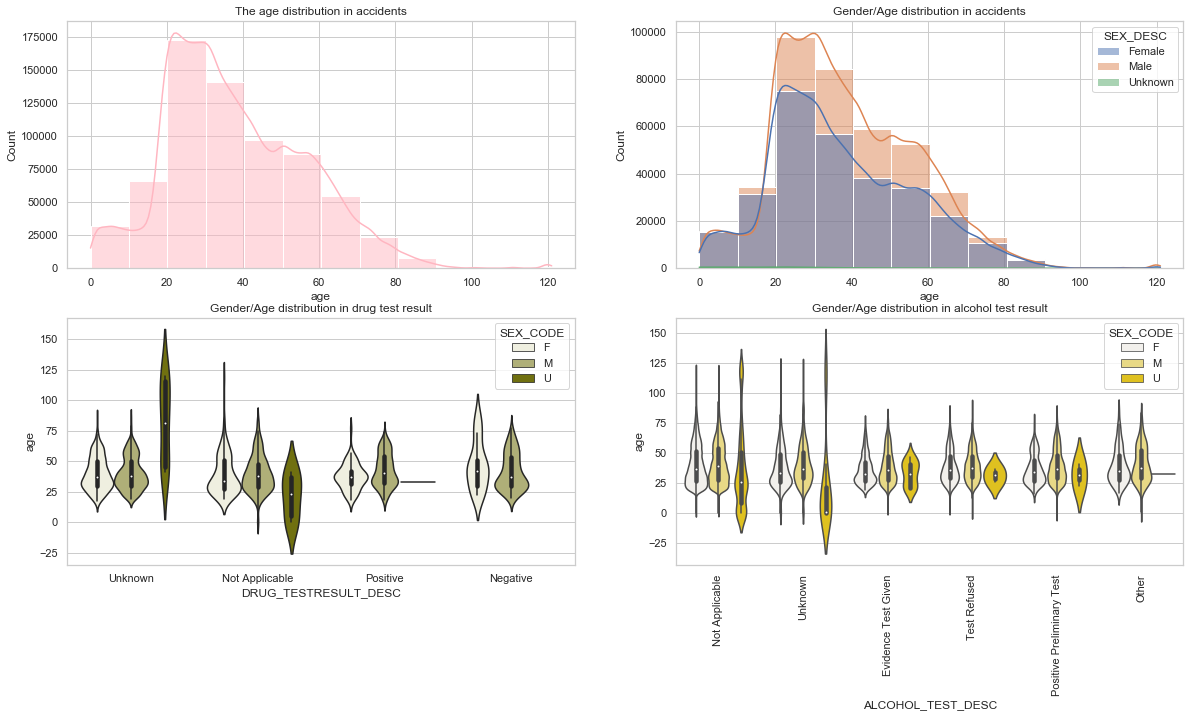

In [ ]:
# Age analysis
sns.set(style='whitegrid')

fig, axs = plt.subplots(2,2, figsize = (20,10)) 

sns.histplot(data = merged_data, x = 'age', bins = 12, 
              kde = True, color = 'lightpink', ax = axs[0,0]).set(title = 'The age distribution in accidents')


sns.histplot(data = merged_data, x = 'age', bins = 12,
             hue = 'SEX_DESC', kde = True, color = 'lightblue', ax = axs[0,1]).set(title = 'Gender/Age distribution in accidents')


sns.violinplot(data = merged_data, x = 'DRUG_TESTRESULT_DESC',y = 'age',
             hue = 'SEX_CODE', kde = True, color = 'olive', ax = axs[1,0]).set(title = 'Gender/Age distribution in drug test result')

sns.violinplot(data = merged_data, x = 'ALCOHOL_TEST_DESC', y= 'age',
              hue = merged_data.SEX_CODE, kde = True, color = 'gold', ax = axs[1,1]).set(title = 'Gender/Age distribution in alcohol test result')
plt.xticks(rotation = 90)






- Unlike the traditional views that teen drivers (under age 20) and senior drivers (age 60-80) tend to have the highest rates of crash involvement, this case shows that adult drivers (age 20-30) have involved the highest numbers of car accidents. This is validated by a new study from AAA Foundation for Traffic Safety: Young adult drivers report engaging in dangerous driving behavior more than any other age group.

- While looking into the gender distribution among these age groups, there’s no significant difference in the number of female and male drivers in teens and seniors. However, among drivers aged 20-60, male drivers have a more significant number of accidents than female drivers. 

- When associating DUI with different age groups, a significant shared feature is that drug and alcohol problems in accidents are primarily focused on the adults' group, which may account for one of the reasons they have the highest involvement in crashes. Specifically, drug use in male drivers is more severe than female drivers, impacting people from a wider age group. 

# 3. Transformation

## 3.1 Handling Missing Values

In [ ]:
merged_data['ACC_TIME']

0         07:25:00
1         07:25:00
2         07:25:00
3         07:25:00
4         07:25:00
            ...   
754287    17:32:00
754288    22:04:00
754289    22:04:00
754290    16:02:00
754291    03:45:00
Name: ACC_TIME, Length: 754284, dtype: object

In [ ]:
merged_data['ACC_DATE']

0         20200826
1         20200826
2         20200826
3         20200826
4         20200826
            ...   
754287    20210719
754288    20210802
754289    20210802
754290    20210804
754291    20210827
Name: ACC_DATE, Length: 754284, dtype: int64

In [ ]:
# Extract year, month, weekday, hour from 'accident_date' and 'accident_datetime'
merged_data['Year'] = merged_data['accident_date'].dt.year
merged_data['Month'] = merged_data['accident_date'].dt.month
merged_data['Weekday'] = merged_data['accident_date'].dt.weekday
merged_data['Hour'] = merged_data['accident_datetime'].dt.hour

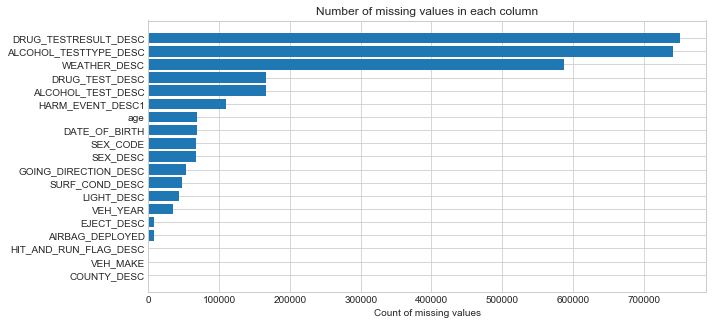

In [ ]:
# Deal with missing data
plt.style.available
plt.style.use('seaborn-whitegrid')

missing_data = merged_data.isnull().sum(axis = 0).reset_index()
missing_data.columns = ['column_name', 'missing_value_count']
missing_data = missing_data.loc[missing_data['missing_value_count'] > 0]
missing_data = missing_data.sort_values(by = 'missing_value_count')

index = np.arange(missing_data.shape[0])
fig,ax = plt.subplots(figsize=(10,5))
rects = ax.barh(index, missing_data.missing_value_count.values)
ax.set_yticks(index)
ax.set_yticklabels(missing_data.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [ ]:
merged_data.shape

(754292, 39)

In [ ]:
# Handling missing values in numeric data 
df = merged_data
df['age'] = df['age'].fillna(df['age'].mean())
df['VEH_YEAR'] = df['VEH_YEAR'].fillna(df['VEH_YEAR'].mean())
df['AIRBAG_DEPLOYED'] = df['AIRBAG_DEPLOYED'].fillna(df['AIRBAG_DEPLOYED'].mean())

In [ ]:
# Handling missing values in categorical data
df['DRUG_TESTRESULT_DESC'] = df['DRUG_TESTRESULT_DESC'].fillna('Unknown')
df['ALCOHOL_TESTTYPE_DESC'] = df['ALCOHOL_TESTTYPE_DESC'].fillna('Unkown')
df['WEATHER_DESC'] = df['WEATHER_DESC'].fillna('Unknown')
df['DRUG_TEST_DESC'] = df['DRUG_TEST_DESC'].fillna('Unknown')
df['ALCOHOL_TEST_DESC'] = df['ALCOHOL_TEST_DESC'].fillna('Unknown')
df['HARM_EVENT_DESC1'] = df['HARM_EVENT_DESC1'].fillna('Unknown')
df['SEX_CODE'] = df['SEX_CODE'].fillna('Unknown')
df['SEX_DESC'] = df['SEX_DESC'].fillna('Unknown')
df['GOING_DIRECTION_DESC'] = df['GOING_DIRECTION_DESC'].fillna('Unknown')
df['SURF_COND_DESC'] = df['SURF_COND_DESC'].fillna('Unknown')
df['LIGHT_DESC'] = df['LIGHT_DESC'].fillna('Unknown')
df['EJECT_DESC'] = df['EJECT_DESC'].fillna('Unknown')
df['HIT_AND_RUN_FLAG_DESC'] = df['HIT_AND_RUN_FLAG_DESC'].fillna('Unknown')
df['VEH_MAKE'] = df['VEH_MAKE'].fillna('Unknown')
df['COUNTY_DESC'] = df['COUNTY_DESC'].fillna('Unknown')

In [ ]:
# Since we've got age, let's drop the date of birth
df = df.drop('DATE_OF_BIRTH',axis = 1)

In [ ]:
df.isnull().mean()

REPORT_NO                0.0
QUARTER                  0.0
LIGHT_DESC               0.0
COUNTY_DESC              0.0
COLLISION_TYPE_DESC      0.0
SURF_COND_DESC           0.0
REPORT_TYPE              0.0
WEATHER_DESC             0.0
HARM_EVENT_DESC1         0.0
HARM_EVENT_DESC2         0.0
ACC_DATE                 0.0
ACC_TIME                 0.0
LATITUDE                 0.0
LONGITUDE                0.0
SEX_DESC                 0.0
SEX_CODE                 0.0
INJ_SEVER_DESC           0.0
ALCOHOL_TEST_DESC        0.0
ALCOHOL_TESTTYPE_DESC    0.0
DRUG_TEST_DESC           0.0
DRUG_TESTRESULT_DESC     0.0
EJECT_DESC               0.0
SAF_EQUIP_DESC           0.0
AIRBAG_DEPLOYED          0.0
YEAR                     0.0
HARM_EVENT_DESC          0.0
VEH_YEAR                 0.0
VEH_MAKE                 0.0
GOING_DIRECTION_DESC     0.0
SPEED_LIMIT              0.0
HIT_AND_RUN_FLAG_DESC    0.0
age                      0.0
accident_date            0.0
accident_datetime        0.0
Year          

## 3.2 Feature Encoding

In [ ]:
# Select the three Counties' subset
select_df = df.loc[(df['COUNTY_DESC'] == 'Baltimore') | (df['COUNTY_DESC'] == 'Baltimore City') | (df['COUNTY_DESC'] == "Prince's George")]

In [ ]:
dtype_select_df = select_df.dtypes.reset_index()
dtype_select_df.columns = ['Data Name', 'Data Type']
dtype_select_df

,Data Name,Data Type
0,REPORT_NO,object
1,QUARTER,object
2,LIGHT_DESC,object
3,COUNTY_DESC,object
4,COLLISION_TYPE_DESC,object
5,SURF_COND_DESC,object
6,REPORT_TYPE,object
7,WEATHER_DESC,object
8,HARM_EVENT_DESC1,object
9,HARM_EVENT_DESC2,object


In [ ]:
select_df.head()

,REPORT_NO,QUARTER,LIGHT_DESC,COUNTY_DESC,COLLISION_TYPE_DESC,SURF_COND_DESC,REPORT_TYPE,WEATHER_DESC,HARM_EVENT_DESC1,HARM_EVENT_DESC2,...,GOING_DIRECTION_DESC,SPEED_LIMIT,HIT_AND_RUN_FLAG_DESC,age,accident_date,accident_datetime,Year,Month,Weekday,Hour
2243,AB41630005,Q3,Daylight,Baltimore,Same Direction Rear End,Dry,Property Damage Crash,Unknown,Other Vehicle,Other Vehicle,...,North,35,No,38.095804,2021-08-03,2021-08-03 06:45:00,2021,8,1,6
2244,AB41630005,Q3,Daylight,Baltimore,Same Direction Rear End,Dry,Property Damage Crash,Unknown,Other Vehicle,Other Vehicle,...,North,35,Yes,38.095804,2021-08-03,2021-08-03 06:45:00,2021,8,1,6
2245,AB41630005,Q3,Daylight,Baltimore,Same Direction Rear End,Dry,Property Damage Crash,Unknown,Other Vehicle,Other Vehicle,...,North,35,No,47.000000,2021-08-03,2021-08-03 06:45:00,2021,8,1,6
2246,AB41630005,Q3,Daylight,Baltimore,Same Direction Rear End,Dry,Property Damage Crash,Unknown,Other Vehicle,Other Vehicle,...,North,35,Yes,47.000000,2021-08-03,2021-08-03 06:45:00,2021,8,1,6
13895,AC1887003H,Q2,Dark Lights On,Baltimore City,Single Vehicle,Dry,Property Damage Crash,Unknown,Fixed Object,Not Applicable,...,West,25,No,17.000000,2021-05-28,2021-05-28 01:36:00,2021,5,4,1


In [ ]:
# Drop unecessary columns for modeling
select_df = select_df.drop(['REPORT_NO', 'ACC_DATE','ACC_TIME','YEAR','accident_date','accident_datetime',
                           'SEX_DESC', 'ALCOHOL_TESTTYPE_DESC','DRUG_TESTRESULT_DESC'],axis = 1)

In [ ]:
select_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271653 entries, 2243 to 706052
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   QUARTER                271653 non-null  object 
 1   LIGHT_DESC             271653 non-null  object 
 2   COUNTY_DESC            271653 non-null  object 
 3   COLLISION_TYPE_DESC    271653 non-null  object 
 4   SURF_COND_DESC         271653 non-null  object 
 5   REPORT_TYPE            271653 non-null  object 
 6   WEATHER_DESC           271653 non-null  object 
 7   HARM_EVENT_DESC1       271653 non-null  object 
 8   HARM_EVENT_DESC2       271653 non-null  object 
 9   LATITUDE               271653 non-null  float64
 10  LONGITUDE              271653 non-null  float64
 11  SEX_CODE               271653 non-null  object 
 12  INJ_SEVER_DESC         271653 non-null  object 
 13  ALCOHOL_TEST_DESC      271653 non-null  object 
 14  DRUG_TEST_DESC         271653 non

In [ ]:
select_df.shape

(271653, 29)

In [ ]:
select_df

,QUARTER,LIGHT_DESC,COUNTY_DESC,COLLISION_TYPE_DESC,SURF_COND_DESC,REPORT_TYPE,WEATHER_DESC,HARM_EVENT_DESC1,HARM_EVENT_DESC2,LATITUDE,...,VEH_YEAR,VEH_MAKE,GOING_DIRECTION_DESC,SPEED_LIMIT,HIT_AND_RUN_FLAG_DESC,age,Year,Month,Weekday,Hour
2243,Q3,Daylight,Baltimore,Same Direction Rear End,Dry,Property Damage Crash,Unknown,Other Vehicle,Other Vehicle,39.376654,...,2019.000000,FORD,North,35,No,38.095804,2021,8,1,6
2244,Q3,Daylight,Baltimore,Same Direction Rear End,Dry,Property Damage Crash,Unknown,Other Vehicle,Other Vehicle,39.376654,...,2006.988616,UNKNOWN,North,35,Yes,38.095804,2021,8,1,6
2245,Q3,Daylight,Baltimore,Same Direction Rear End,Dry,Property Damage Crash,Unknown,Other Vehicle,Other Vehicle,39.376654,...,2019.000000,FORD,North,35,No,47.000000,2021,8,1,6
2246,Q3,Daylight,Baltimore,Same Direction Rear End,Dry,Property Damage Crash,Unknown,Other Vehicle,Other Vehicle,39.376654,...,2006.988616,UNKNOWN,North,35,Yes,47.000000,2021,8,1,6
13895,Q2,Dark Lights On,Baltimore City,Single Vehicle,Dry,Property Damage Crash,Unknown,Fixed Object,Not Applicable,39.237617,...,2015.000000,VOLKSWAGEN,West,25,No,17.000000,2021,5,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706048,Q3,Daylight,Baltimore,Single Vehicle,Unknown,Property Damage Crash,Unknown,Fixed Object,Not Applicable,39.394745,...,1992.000000,CHEVY,East,5,No,68.000000,2020,8,4,12
706049,Q1,Daylight,Baltimore,Same Direction Right Turn,Unknown,Property Damage Crash,Raining,Unknown,Not Applicable,39.407348,...,2007.000000,HONDA,North,5,No,41.000000,2020,2,1,10
706050,Q1,Daylight,Baltimore,Same Direction Right Turn,Unknown,Property Damage Crash,Raining,Unknown,Not Applicable,39.407348,...,2014.000000,FORD,North,5,No,41.000000,2020,2,1,10
706051,Q1,Daylight,Baltimore,Same Direction Right Turn,Unknown,Property Damage Crash,Raining,Unknown,Not Applicable,39.407348,...,2007.000000,HONDA,North,5,No,23.000000,2020,2,1,10


In [ ]:
# Define one hot encoding
labelencoder = LabelEncoder()
# transform data
select_df_dummy3.iloc[:,0] = labelencoder.fit_transform(select_df_dummy3.iloc[:,0])

In [ ]:
select_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271653 entries, 2243 to 706052
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   QUARTER                271653 non-null  object 
 1   LIGHT_DESC             271653 non-null  object 
 2   COUNTY_DESC            271653 non-null  object 
 3   COLLISION_TYPE_DESC    271653 non-null  object 
 4   SURF_COND_DESC         271653 non-null  object 
 5   REPORT_TYPE            271653 non-null  object 
 6   WEATHER_DESC           271653 non-null  object 
 7   HARM_EVENT_DESC1       271653 non-null  object 
 8   HARM_EVENT_DESC2       271653 non-null  object 
 9   LATITUDE               271653 non-null  float64
 10  LONGITUDE              271653 non-null  float64
 11  SEX_CODE               271653 non-null  object 
 12  INJ_SEVER_DESC         271653 non-null  object 
 13  ALCOHOL_TEST_DESC      271653 non-null  object 
 14  DRUG_TEST_DESC         271653 non

In [ ]:
# Generate dummies for categorical data
select_df_dummy3 = pd.get_dummies(select_df, drop_first=True, 
                                 columns = ['LIGHT_DESC', 'COLLISION_TYPE_DESC','SURF_COND_DESC','WEATHER_DESC','HARM_EVENT_DESC1',
                                           'HARM_EVENT_DESC2','SEX_CODE', 'INJ_SEVER_DESC', 'QUARTER','ALCOHOL_TEST_DESC',
                                           'DRUG_TEST_DESC', 'EJECT_DESC', 'SAF_EQUIP_DESC','HARM_EVENT_DESC', 'VEH_MAKE',
                                            'GOING_DIRECTION_DESC','HIT_AND_RUN_FLAG_DESC'])


In [ ]:
select_df_dummy3 = pd.get_dummies(select_df_dummy3, drop_first = True,
                                columns = ['COUNTY_DESC'])

In [ ]:
select_df_dummy3

,REPORT_TYPE,LATITUDE,LONGITUDE,AIRBAG_DEPLOYED,VEH_YEAR,SPEED_LIMIT,age,Year,Month,Weekday,...,VEH_MAKE_ZHNG,VEH_MAKE_`BUIC,VEH_MAKE_`TOYOTA,GOING_DIRECTION_DESC_North,GOING_DIRECTION_DESC_South,GOING_DIRECTION_DESC_Unknown,GOING_DIRECTION_DESC_West,HIT_AND_RUN_FLAG_DESC_Unknown,HIT_AND_RUN_FLAG_DESC_Yes,COUNTY_DESC_Baltimore City
2243,2,39.376654,-76.450234,1.0,2019.000000,35,38.095804,2021,8,1,...,0,0,0,1,0,0,0,0,0,0
2244,2,39.376654,-76.450234,1.0,2006.988616,35,38.095804,2021,8,1,...,0,0,0,1,0,0,0,0,1,0
2245,2,39.376654,-76.450234,1.0,2019.000000,35,47.000000,2021,8,1,...,0,0,0,1,0,0,0,0,0,0
2246,2,39.376654,-76.450234,1.0,2006.988616,35,47.000000,2021,8,1,...,0,0,0,1,0,0,0,0,1,0
13895,2,39.237617,-76.582539,4.0,2015.000000,25,17.000000,2021,5,4,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706048,2,39.394745,-76.608645,1.0,1992.000000,5,68.000000,2020,8,4,...,0,0,0,0,0,0,0,0,0,0
706049,2,39.407348,-76.630082,1.0,2007.000000,5,41.000000,2020,2,1,...,0,0,0,1,0,0,0,0,0,0
706050,2,39.407348,-76.630082,1.0,2014.000000,5,41.000000,2020,2,1,...,0,0,0,1,0,0,0,0,0,0
706051,2,39.407348,-76.630082,1.0,2007.000000,5,23.000000,2020,2,1,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# Property Damage Crash - 2, Injury Crash - 1, Fatal Crash - 0
select_df_dummy3.REPORT_TYPE.unique()

array([2, 1, 0])

## 4. Modeling

In [ ]:
# Set X and y
X = select_df_dummy3.iloc[:, 1:2021]
y = select_df_dummy3.iloc[:,0]

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify = y)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rele

In [ ]:
# List of classification algorithms
algorithm_list=['Logistic Regression',' K-Nearest Neighbors','Decision Trees','Random Forest']

# Initialize an empty list for the accuracy for each algorithm
accuracy_list=[]

## 

In [ ]:
# Logistic regression
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append the score to the accuracy list
accuracy_list.append(acc)

print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[Logistic regression algorithm] accuracy_score: 0.852.


In [ ]:
# KNN (The K-Nearest Neighbors) algorithm
knn = KNeighborsClassifier(n_neighbors = 6)

# Fit the classifier to the data
knn.fit(X_train, y_train)

# Predict the results for training data
y_pred = knn.predict(X_test)

# Get the accuracy score
acc = accuracy_score(y_test, y_pred)

# Append the score to the accruacy list
accuracy_list.append(acc)

print('[K-Nearest Neighbors (KNN)] knn.score: {:.3f}.'.format(knn.score(X_test, y_test)))
print('[K-Nearest Neighbors (KNN)] accuracy_score: {:.3f}.'.format(acc))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


[K-Nearest Neighbors (KNN)] knn.score: 0.736.
[K-Nearest Neighbors (KNN)] accuracy_score: 0.736.


In [ ]:
# Random Forest - n_estimators = 100
clf = RandomForestClassifier(n_estimators = 100)
# Train the model and predict the results
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Get the accuracy score
acc = accuracy_score(y_test, y_pred)

# Append the score to the accuracy list
accuracy_list.append(acc)

# Print the model accuracy
print("[Random Forest Algorithm] accuracy_score: {:.3f}.".format(acc))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curr

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

[Random Forest Algorithm] accuracy_score: 0.925.


No handles with labels found to put in legend.


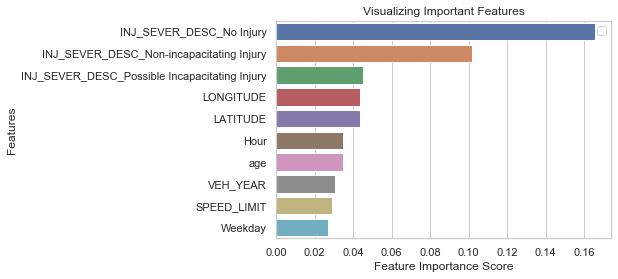

In [ ]:
# Random Forest - visualize important features
feature_imp = pd.Series(clf.feature_importances_, index = X.columns).sort_values(ascending = False)
# Create a bar plot for the top k features
k = 10
sns.set_theme(style='whitegrid')
sns.barplot(x = feature_imp[:10], y =feature_imp.index[:k])
# Add details to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features')
plt.legend()
plt.show()

In [ ]:
# List the top k important features
k = 20
feature_imp.sort_values(ascending = False)[:k]

INJ_SEVER_DESC_No Injury                         0.165721
INJ_SEVER_DESC_Non-incapacitating Injury         0.101758
INJ_SEVER_DESC_Possible Incapacitating Injury    0.045081
LONGITUDE                                        0.043471
LATITUDE                                         0.043370
Hour                                             0.034849
age                                              0.034694
VEH_YEAR                                         0.030747
SPEED_LIMIT                                      0.028990
Weekday                                          0.027096
Month                                            0.026505
AIRBAG_DEPLOYED                                  0.024737
HIT_AND_RUN_FLAG_DESC_Yes                        0.009980
Year                                             0.009231
HARM_EVENT_DESC_Pedestrian                       0.009133
SEX_CODE_Unknown                                 0.009056
COUNTY_DESC_Baltimore City                       0.008640
LIGHT_DESC_Day

In [ ]:
# Select the top imporant features while settingg up a threshold
# Create an object applying the random forest classifier to identify features that reach and beyond the threshold 0.02
sfm = SelectFromModel(clf, threshold = 0.02)

# Fit the selector with training set data
sfm.fit(X_train, y_train)
feat_labels = X.columns

# Print out these selected important features
for feature_list_index in sfm.get_support(indices = True):
    print(feat_labels[feature_list_index])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curr

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

LATITUDE
LONGITUDE
AIRBAG_DEPLOYED
VEH_YEAR
SPEED_LIMIT
age
Month
Weekday
Hour
INJ_SEVER_DESC_No Injury
INJ_SEVER_DESC_Non-incapacitating Injury
INJ_SEVER_DESC_Possible Incapacitating Injury


In [ ]:
# Create a new dataset containing these important features 
# Transform them to both training and test sets
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for these important features
clf_important = RandomForestClassifier(n_estimators = 100, random_state = 0, n_jobs = -1)

# Train the classifier to new datasets again
clf_important.fit(X_important_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curr

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
# Apply the previous classifier to the test data
y_pred = clf.predict(X_test)
# Take a look at the accuracy of the previous model
print('[Random Forest Algorithm with general features] accuracy score: {:.3f}.'.format(accuracy_score(y_test, y_pred)))
# Apply this new classifier to the test data
y_important_pred = clf_important.predict(X_important_test)
# Take a look at the accuracy of the new model
print('[Random Forest Algorithm with limited features] accuracy score: {:.3f}.'.format(accuracy_score(y_test, y_important_pred)))

acc = accuracy_score(y_test,y_important_pred)
accuracy_list.append(acc)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


[Random Forest Algorithm with general features] accuracy score: 0.925.


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


[Random Forest Algorithm with limited features] accuracy score: 0.932.


In [ ]:
acc = accuracy_score(y_test,y_important_pred)
accuracy_list.append(acc)

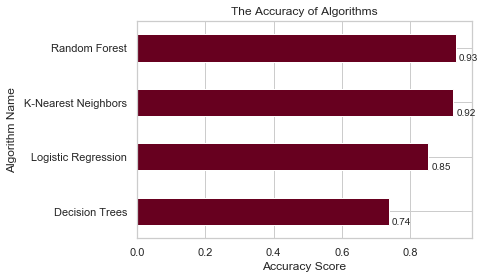

In [ ]:
# Visualize the accuracy of the algorithms

# Add the y ticks
y_ticks = np.arange(len(algorithm_list))
# Convert the lists we created before to a dataframe
df_acc = pd.DataFrame(list(zip(algorithm_list, accuracy_list)), columns = ['Algorithm Name','Accuracy Score']).sort_values(by = ['Accuracy Score'], ascending = True)
# Create the plot
ax = df_acc.plot.barh('Algorithm Name', 'Accuracy Score', align = 'center', legend = False, colormap='RdBu')
for i in ax.patches:
    ax.text(i.get_width()+0.01, i.get_y()+0.01, str(round(i.get_width(), 2)), fontsize = 10)

# Add labels 
plt.xlabel('Accuracy Score')
plt.yticks(y_ticks, df_acc['Algorithm Name'], rotation = 0)
plt.title('The Accuracy of Algorithms')
plt.show()
    

## 5. Feature Engineering

# 6. Results

In [ ]:
person.shape

(372049, 14)

In [ ]:
person.head()

,YEAR,Quarter,SEX_DESC,SEX_CODE,INJ_SEVER_DESC,REPORT_NO,ALCOHOL_TEST_DESC,ALCOHOL_TESTTYPE_DESC,DRUG_TEST_DESC,DRUG_TESTRESULT_DESC,EJECT_DESC,SAF_EQUIP_DESC,DATE_OF_BIRTH,AIRBAG_DEPLOYED
0,2020,Q1,Female,F,Possible Incapacitating Injury,DA32230016,Not Applicable,NaN,Not Applicable,NaN,Not Applicable,Shoulder/Lap Belt(s),19911106.0,4.0
1,2020,Q1,NaN,NaN,No Injury,DA40360040,Not Applicable,NaN,Not Applicable,NaN,Unknown,Unknown,NaN,0.0
2,2020,Q1,Male,M,No Injury,MDTA1655001L,Not Applicable,NaN,Not Applicable,NaN,Not Ejected/Trapped,Shoulder/Lap Belt(s),19901231.0,1.0
3,2020,Q1,Male,M,No Injury,CB60350070,Not Applicable,NaN,Not Applicable,NaN,Not Ejected/Trapped,Shoulder/Lap Belt(s),19521119.0,0.0
4,2020,Q1,Female,F,No Injury,MSP71270044,NaN,NaN,NaN,NaN,Not Applicable,Shoulder/Lap Belt(s),19950601.0,1.0


In [ ]:
crash.shape

(171577, 16)

In [ ]:
crash.head()

,YEAR,QUARTER,LIGHT_DESC,COUNTY_DESC,COLLISION_TYPE_DESC,SURF_COND_DESC,REPORT_NO,REPORT_TYPE,WEATHER_DESC,HARM_EVENT_DESC1,HARM_EVENT_DESC2,ACC_DATE,ACC_TIME,LATITUDE,LONGITUDE,LOCATION
0,2020,Q2,Daylight,Baltimore,Other,NaN,AE58770052,Property Damage Crash,Not Applicable,Parked Vehicle,Not Applicable,20200618,15:15:00,39.277263,-76.503693,POINT (-76.5036932 39.27726285)
1,2020,Q2,NaN,Baltimore City,Other,Dry,ADJ984001J,Injury Crash,NaN,Other Vehicle,Other Vehicle,20200430,06:39:00,39.311025,-76.616429,POINT (-76.616429453205 39.311024794431)
2,2020,Q2,Daylight,Montgomery,Other,NaN,EJ7878001D,Injury Crash,NaN,Pedestrian,Not Applicable,20200504,09:46:00,39.140680,-77.193413,POINT (-77.193412729561 39.140680249069)
3,2020,Q2,Daylight,Cecil,Same Direction Rear End,NaN,MSP6709008R,Property Damage Crash,NaN,Other Vehicle,Not Applicable,20200414,17:32:00,39.611028,-75.951314,POINT (-75.951314 39.611027833333)
4,2020,Q2,Daylight,Anne Arundel,Other,NaN,AC2358001F,Property Damage Crash,NaN,Other Vehicle,Not Applicable,20200616,17:10:00,39.095746,-76.694121,POINT (-76.694121483333 39.09574595)


In [ ]:
vehicle.shape

(316389, 9)

In [ ]:
vehicle.head()

,YEAR,Quarter,REPORT_NO,HARM_EVENT_DESC,VEH_YEAR,VEH_MAKE,GOING_DIRECTION_DESC,SPEED_LIMIT,HIT_AND_RUN_FLAG_DESC
0,2020,Q2,AE5057004X,Other Vehicle,NaN,UNKNOWN,North,25,Yes
1,2020,Q2,MSP7221001P,Other Vehicle,2018.0,TOYOTA,North,55,No
2,2020,Q2,DA37010040,Other Vehicle,2019.0,CHEVROLET,South,30,No
3,2020,Q2,MDTA1791002C,Fixed Object,NaN,UNKNOWN,Unknown,35,Yes
4,2020,Q2,AE456100BL,Other Vehicle,2002.0,HONDA,East,35,No


In [ ]:
merged_data.shape

(754292, 37)

In [ ]:
merged_data.head()

,REPORT_NO,YEAR.x,QUARTER,LIGHT_DESC,COUNTY_DESC,COLLISION_TYPE_DESC,SURF_COND_DESC,REPORT_TYPE,WEATHER_DESC,HARM_EVENT_DESC1,...,DATE_OF_BIRTH,AIRBAG_DEPLOYED,YEAR,Quarter.y,HARM_EVENT_DESC,VEH_YEAR,VEH_MAKE,GOING_DIRECTION_DESC,SPEED_LIMIT,HIT_AND_RUN_FLAG_DESC
0,AA0020000Y,2020,Q3,Daylight,Harford,Head On,Dry,Injury Crash,NaN,Other Vehicle,...,19750913.0,4.0,2020,Q3,Other Vehicle,2003.0,HONDA,South,30,No
1,AA0020000Y,2020,Q3,Daylight,Harford,Head On,Dry,Injury Crash,NaN,Other Vehicle,...,19750913.0,4.0,2020,Q3,Other Vehicle,2016.0,CHEVY,North,30,No
2,AA0020000Y,2020,Q3,Daylight,Harford,Head On,Dry,Injury Crash,NaN,Other Vehicle,...,19650124.0,2.0,2020,Q3,Other Vehicle,2003.0,HONDA,South,30,No
3,AA0020000Y,2020,Q3,Daylight,Harford,Head On,Dry,Injury Crash,NaN,Other Vehicle,...,19650124.0,2.0,2020,Q3,Other Vehicle,2016.0,CHEVY,North,30,No
4,AA0020000Y,2020,Q3,Daylight,Harford,Head On,Dry,Injury Crash,NaN,Other Vehicle,...,19670930.0,2.0,2020,Q3,Other Vehicle,2003.0,HONDA,South,30,No


# The crash accidents happened in each county

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

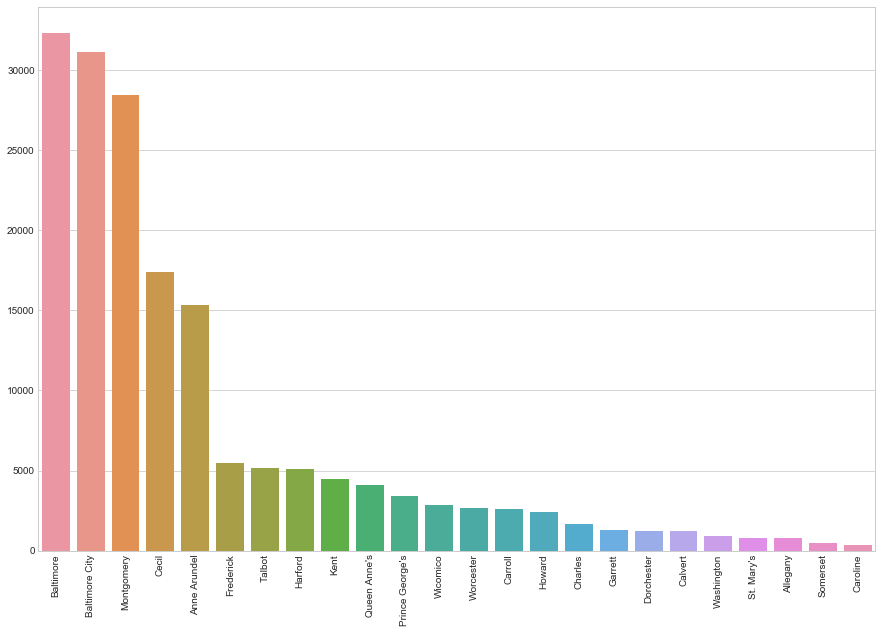

In [ ]:
county = crash.COUNTY_DESC.unique()

count_by_county = []

for i in crash.COUNTY_DESC.unique():
    count_by_county.append(crash[crash['COUNTY_DESC'] == i].count()['COUNTY_DESC'])
    count_by_county.sort(reverse=True)

fig,ax = plt.subplots(figsize=(15,10))
sns.barplot(county, count_by_county)
plt.xticks(rotation = 90)
plt.title('')